In [8]:
#imports
import numpy as np
import matplotlib.pyplot as plt

#audio
from pydub import AudioSegment
from pydub.utils import make_chunks

#audio feature extraction library
import librosa
from librosa import feature

#model
import tensorflow as tf
from sklearn.model_selection import train_test_split
import soundfile as sf

import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers.embeddings import Embedding

#Other
import os
from glob import glob
import time
import pickle

In [9]:
speakers = ["Obama", "Hillary", "Ivanka", "Trump", "No Speaker", "Modi", "Xi-Jinping", "Chadwick-Boseman"]

In [10]:
def findAllAudioFilePaths():
    audioFilesPaths = [y for x in os.walk("Dataset/Youtube Speech Dataset/Dataset") for y in glob(os.path.join(x[0], '*.wav'))]
    return audioFilesPaths

In [11]:
def speakerToLabel(speakerName):
    #index = speakers.index(speakerName)
    
    #if(index == -1):
    #    print("Speaker not found: {}".format(speakerName))
    
    if(speakerName == "No Speaker"):
        return 0
    else:
        return 1
    
    
    #return index

In [12]:
def getSpeakerAndAudio(audioPaths):
    audio_Paths = []
    labels = []
    uniqueSpeakers = {}

    for audioPath in audioPaths:
        speakerName = audioPath.split("/")[3]

        audioLength = librosa.get_duration(filename=audioPath)
        
        if audioLength == 1.0:
            audio_Paths.append(audioPath)
            labels.append(speakerToLabel(speakerName))
            uniqueSpeakers[speakerName] = uniqueSpeakers.get(speakerName, 0) + 1
        else:
            print("Audio clip discarded, actual length = {}".format(audioLength))
    
    return audio_Paths, labels, uniqueSpeakers

In [13]:
 #https://towardsdatascience.com/how-i-understood-what-features-to-consider-while-training-audio-files-eedfb6e9002b
        
def getFeatures(audio_Paths):
    
    data_X = []
    
    for path in audio_Paths:
        
        audioFeatureArray = []        
        y, sr = librosa.load(path)
        
        #mfcc
        mfccArray = librosa.feature.mfcc(y=y, sr=sr)
        audioFeatureArray.append(mfccArray.flatten())
        audioFeatureNumpyArray = np.array(audioFeatureArray)
        
        #zero_crossing_rate
        zeroCrossingArray = librosa.feature.zero_crossing_rate(y=y)
        np.append(audioFeatureNumpyArray, zeroCrossingArray.flatten())
        
        #spectral_rolloff
        spectralRollOffArray = librosa.feature.spectral_rolloff(y=y, sr=sr)
        np.append(audioFeatureNumpyArray, spectralRollOffArray.flatten())
        
        #pitch and magnitude
        pitchArray, magnitudeArray = librosa.piptrack(y=y, sr=sr)
        np.append(audioFeatureNumpyArray, pitchArray.flatten())
        np.append(audioFeatureNumpyArray, magnitudeArray.flatten())
        
        
        data_X.append(audioFeatureNumpyArray.flatten())
        
        
    return data_X

In [14]:
%%script false --no-raise-error #makes this code not run

print("This code cell should not run")

audioPaths = findAllAudioFilePaths()
audio_Paths, labels, uniqueSpeakers = getSpeakerAndAudio(audioPaths)
 

print("")
print("-------------------------")
for speaker in uniqueSpeakers: 
    print("Speaker: {}, length: {} minutes".format(speaker, int(uniqueSpeakers[speaker])/60 )) 
print("-------------------------")
print("")


print("Total Dataset size: {}".format(len(audio_Paths)))

startTime = time.time()
data_X = getFeatures(audio_Paths)
endTime = time.time()

print("Time to extract Features {} minutes".format( (endTime-startTime)/60))

print("X data: {}".format(len(data_X)))
print("Y data: {}".format(len(labels)))


############
print("")

print("Creating Dataset X pickel")
pickle_dataX = open("dataX.pickle","wb")
pickle.dump(data_X, pickle_dataX)
pickle_dataX.close()

print("Creating Dataset Y pickel")
pickle_dataY = open("dataY.pickle","wb")
pickle.dump(labels, pickle_dataY)
pickle_dataY.close()
############

In [15]:
#######
print("Loading Dataset X from pickel")
pickle_dataX = open("dataX.pickle","rb")
data_X = pickle.load(pickle_dataX)

print("Loading Dataset Y from pickel")
pickle_dataY = open("dataY.pickle","rb")
labels = pickle.load(pickle_dataY)
#######


train_X, test_X, train_Y, test_Y = train_test_split(data_X, labels, test_size=0.2)

train_x = np.array(train_X)
train_y = np.array(train_Y)
test_x = np.array(test_X)
test_y = np.array(test_Y)

train_y = tf.keras.utils.to_categorical(train_y)
test_y = tf.keras.utils.to_categorical(test_y)


Loading Dataset X from pickel
Loading Dataset Y from pickel


In [23]:
# create a model
#from tf.keras.layers import Dense

def create_model():
    model = tf.keras.Sequential()
    
    """"
    model.add(tf.keras.layers.Dense(12,input_shape= train_x.shape, activation='relu'))
    model.add(tf.keras.layers.Dense(8, activation='relu'))
    model.add(tf.keras.layers.Dense(len(speakers), activation="softmax"))
    """
    
    model.add(Dense(128, input_shape= train_x.shape, activation='relu'))
    #model.add(Dense(64, activation='relu'))
    #model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(2, activation="sigmoid"))
    
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=3e-4)
            , loss = "binary_crossentropy"
            , metrics = ["accuracy"])
                          
    
    
    return model

Epoch 1/19
371/371 [==============================] - 1s 2ms/step - loss: 0.3937 - accuracy: 0.9785 - val_loss: 0.0628 - val_accuracy: 0.9976
Epoch 2/19
371/371 [==============================] - 1s 1ms/step - loss: 0.0310 - accuracy: 0.9983 - val_loss: 0.0097 - val_accuracy: 0.9993
Epoch 3/19
371/371 [==============================] - 1s 1ms/step - loss: 0.0071 - accuracy: 0.9992 - val_loss: 0.0044 - val_accuracy: 0.9993
Epoch 4/19
371/371 [==============================] - 1s 1ms/step - loss: 0.0045 - accuracy: 0.9993 - val_loss: 0.0039 - val_accuracy: 0.9993
Epoch 5/19
371/371 [==============================] - 0s 1ms/step - loss: 0.0036 - accuracy: 0.9993 - val_loss: 0.0041 - val_accuracy: 0.9993
Epoch 6/19
371/371 [==============================] - 1s 1ms/step - loss: 0.0037 - accuracy: 0.9993 - val_loss: 0.0036 - val_accuracy: 0.9993
Epoch 7/19
371/371 [==============================] - 1s 1ms/step - loss: 0.0222 - accuracy: 0.9984 - val_loss: 0.0045 - val_accuracy: 0.9993
Epoch 

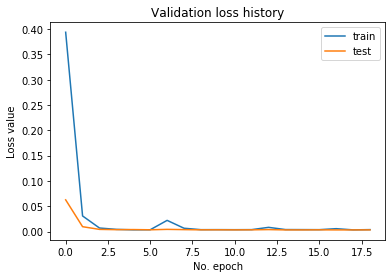

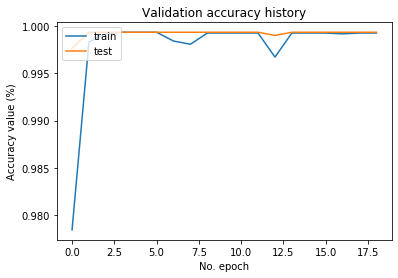

In [24]:
model = create_model()

model.fit(x=train_x, y=train_y, epochs=19, verbose=1,  validation_data=(test_x, test_y))



# Plot history: Loss
plt.plot(model.history.history['loss'], label="train")
plt.plot(model.history.history['val_loss'], label="test")
plt.title('Validation loss history')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")
plt.show()

# Plot history: Accuracy
plt.plot(model.history.history['accuracy'], label="train")
plt.plot(model.history.history['val_accuracy'], label="test")
plt.title('Validation accuracy history')
plt.ylabel('Accuracy value (%)')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [25]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 11847, 128)        112768    
_________________________________________________________________
dense_11 (Dense)             (None, 11847, 16)         2064      
_________________________________________________________________
dense_12 (Dense)             (None, 11847, 2)          34        
Total params: 114,866
Trainable params: 114,866
Non-trainable params: 0
_________________________________________________________________


In [19]:
#save the model t
model.save('Trained Model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: Trained Model/assets
